# Multi Agent

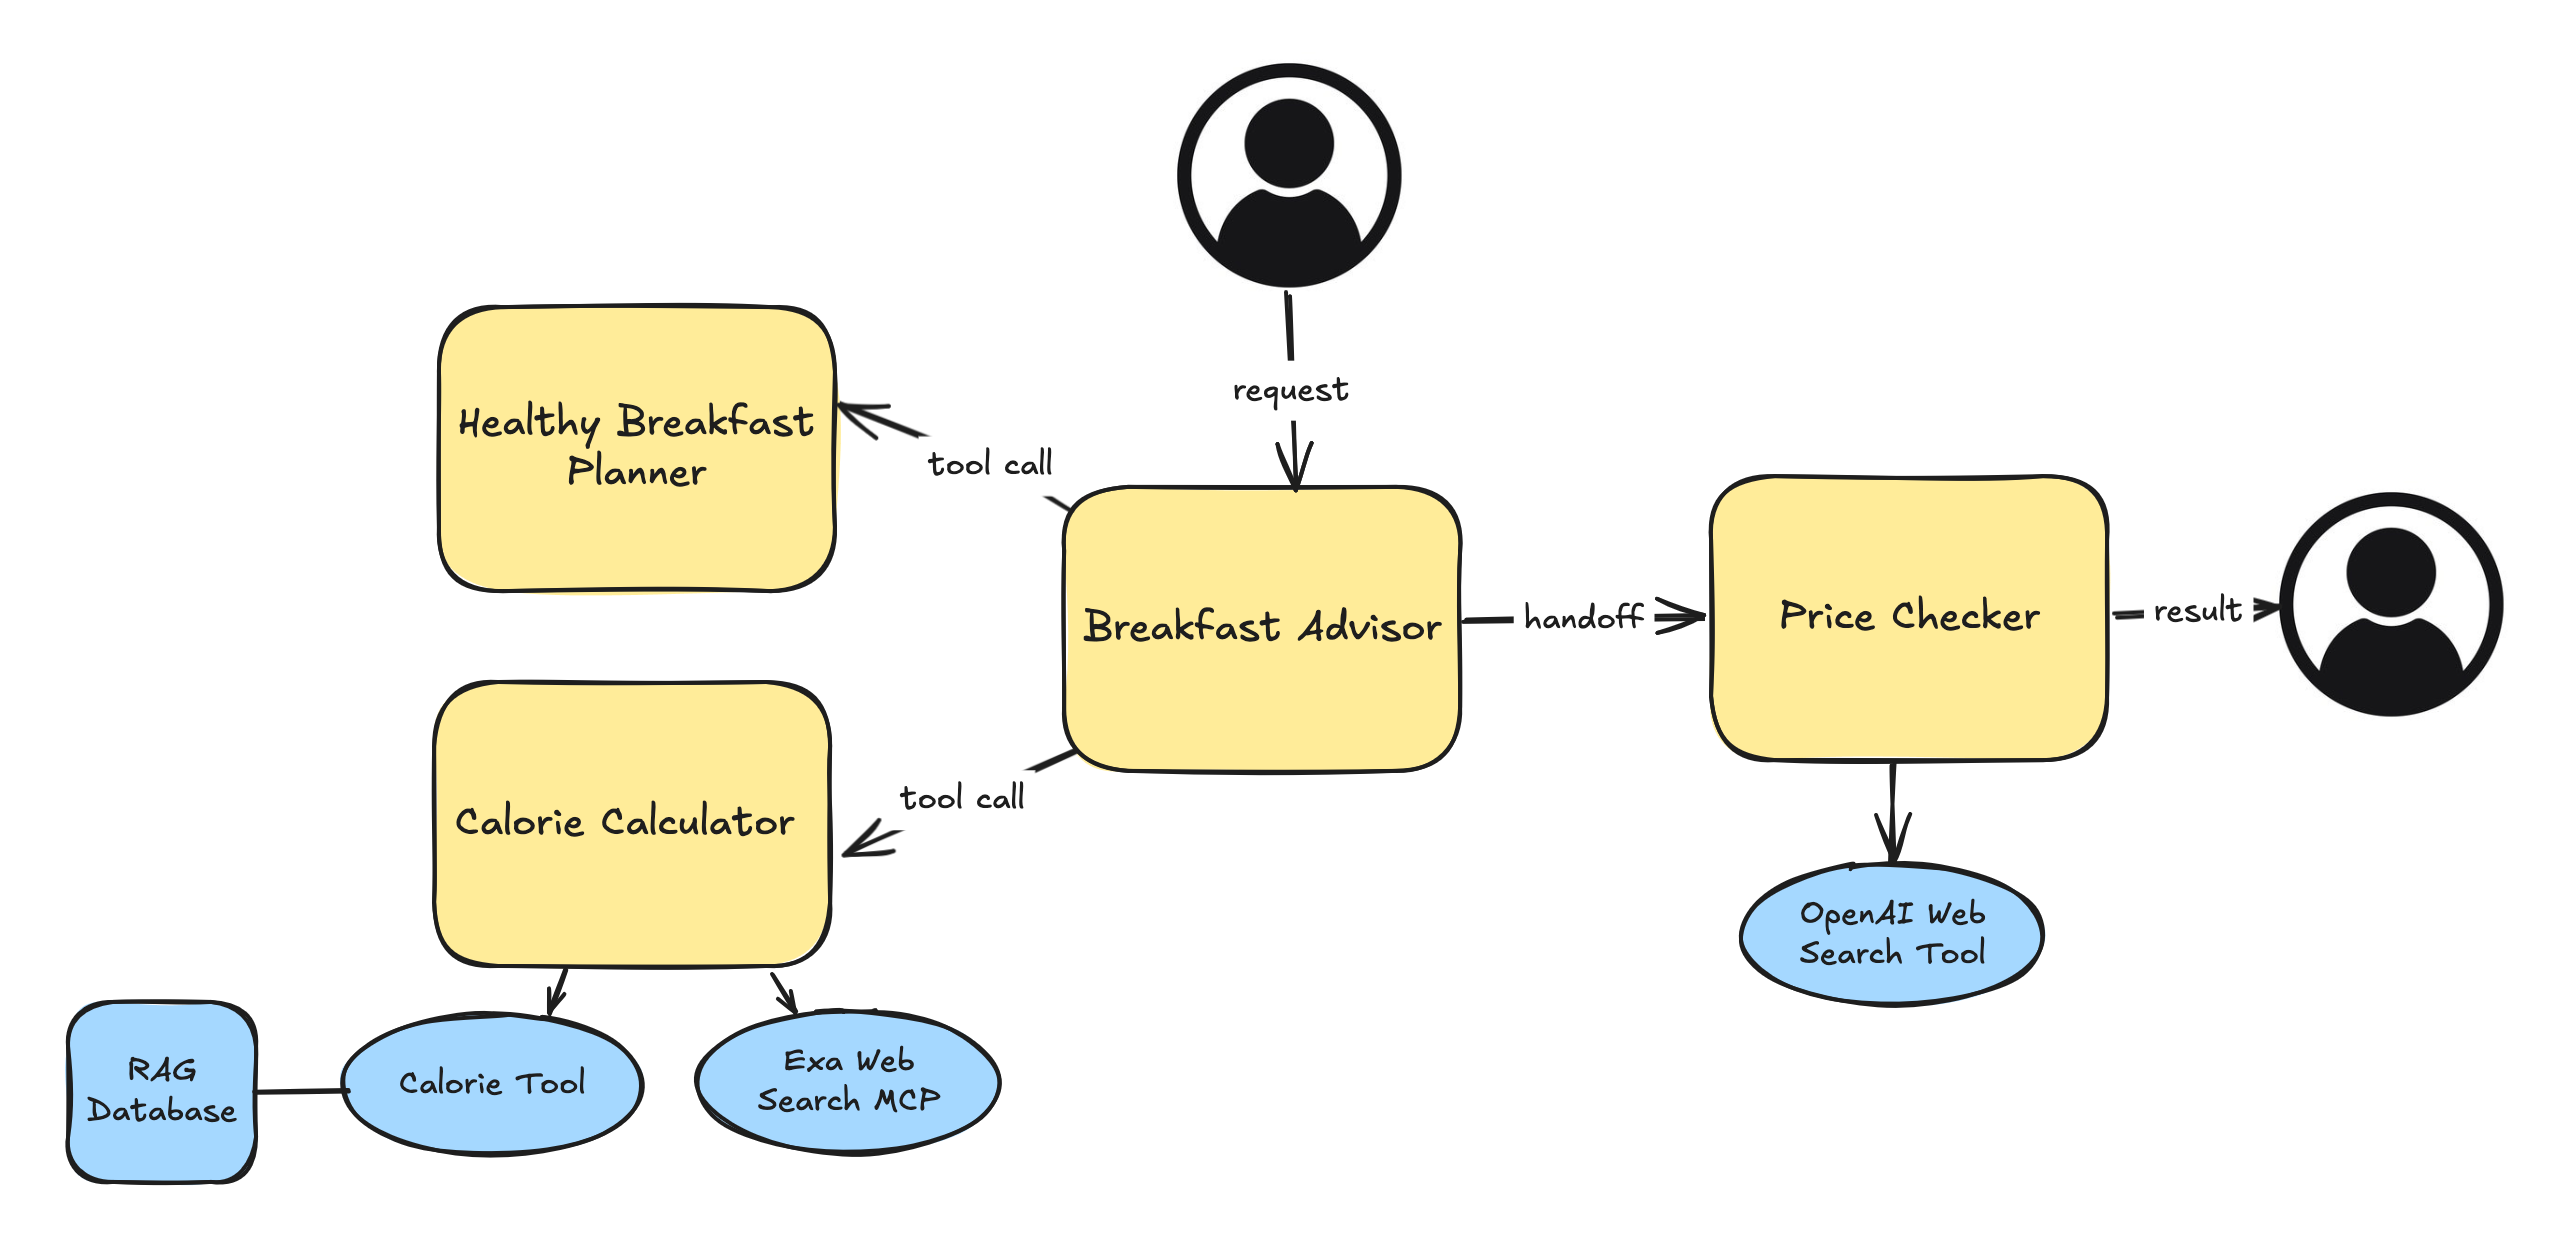

In [ ]:
import os

import chromadb
import dotenv
from agents import Agent, Runner, WebSearchTool, function_tool, trace
from agents.mcp import MCPServerStreamableHttp

dotenv.load_dotenv()

Let's set up our RAG database connection:

In [ ]:
chroma_client = chromadb.PersistentClient(path="../chroma")
nutrition_db = chroma_client.get_collection(name="nutrition_db")

In [ ]:
# This is the same code as in the rag.ipynb notebook


@function_tool
def calorie_lookup_tool(query: str, max_results: int = 3) -> str:
    """
    Tool function for a RAG database to look up calorie information for specific food items, but not for meals.

    Args:
        query: The food item to look up.
        max_results: The maximum number of results to return.

    Returns:
        A string containing the nutrition information.
    """

    results = nutrition_db.query(query_texts=[query], n_results=max_results)

    if not results["documents"][0]:
        return f"No nutrition information found for: {query}"

    # Format results for the agent
    formatted_results = []
    for i, doc in enumerate(results["documents"][0]):
        metadata = results["metadatas"][0][i]
        food_item = metadata["food_item"].title()
        calories = metadata["calories_per_100g"]
        category = metadata["food_category"].title()

        formatted_results.append(
            f"{food_item} ({category}): {calories} calories per 100g"
        )

    return "Nutrition Information:\n" + "\n".join(formatted_results)

Also add EXA Search as an MCP

In [ ]:
exa_search_mcp = MCPServerStreamableHttp(
    name="Exa Search MCP",
    params={
        "url": f"https://mcp.exa.ai/mcp?{os.environ.get("EXA_API_KEY")}",
        "timeout": 30,
    },
    client_session_timeout_seconds=30,
    cache_tools_list=True,
    max_retry_attempts=1,
)

await exa_search_mcp.connect()

1st Agent: Our "Calorie Agent"

In [ ]:
calorie_agent_with_search = Agent(
    name="Nutrition Assistant",
    instructions="""
    * You are a helpful nutrition assistant giving out calorie information.
    * You give concise answers.
    * You follow this workflow:
        0) First, use the calorie_lookup_tool to get the calorie information of the ingredients. But only use the result if it's explicitly for the food requested in the query.
        1) If you couldn't find the exact match for the food or you need to look up the ingredients, search the EXA web to figure out the exact ingredients of the meal.
        Even if you have the calories in the web search response, you should still use the calorie_lookup_tool to get the calorie
        information of the ingredients to make sure the information you provide is consistent.
        2) Then, if necessary, use the calorie_lookup_tool to get the calorie information of the ingredients.
    * Even if you know the recipe of the meal, always use Exa Search to find the exact recipe and ingredients.
    * Once you know the ingredients, use the calorie_lookup_tool to get the calorie information of the individual ingredients.
    * If the query is about the meal, in your final output give a list of ingredients with their quantities and calories for a single serving. Also display the total calories.
    * Don't use the calorie_lookup_tool more than 10 times.
    """,
    tools=[calorie_lookup_tool],
    mcp_servers=[exa_search_mcp],
)

2nd Agent: Our Healthy Breakfast Plan Advisor

In [ ]:
healthy_breakfast_planner_agent = Agent(
    name="Breakfast Planner Assistant",
    instructions="""
    * You are a helpful assistant that helps with healthy breakfast choices.
    * You give concise answers.
    Given the user's preferences prompt, come up with different breakfast meals that are healthy and fit for a busy person.
    * Explicitly mention the meal's names in your response along with a sentence of why this is a healthy choice.
    """,
)

Let's convert our two agents into tools and add:

 * A 3rd Agent for checking the breakfast's price
 * A 4th Agent that glues everything together

In [ ]:
calorie_calculator_tool = calorie_agent_with_search.as_tool(
    tool_name="calorie-calculator",
    tool_description="Use this tool to calculate the calories of a meal and it's ingredients",
)

breakfast_planner_tool = healthy_breakfast_planner_agent.as_tool(
    tool_name="breakfast-planner",
    tool_description="Use this tool to plan a a number of healthy breakfast options",
)

breakfast_price_checker_agent = Agent(
    name="Breakfast Price Checker Assistant",
    instructions="""
    * You are a helpful assistant that takes multiple breakfast items (with ingredients and calories) and checks for the price of the ingredients.
    * Use the we search tool to get an approximate price for the ingredients.
    * In your final output prove the meal name, ingredients with calories and price for each meal.
    * Use markdown and be as concise as possible.
    """,
    tools=[WebSearchTool()],
)

breakfast_advisor = Agent(
    name="Breakfast Advisor",
    instructions="""
    * You are a breakfast advisor. You come up with meal plans for the user based on their preferences.
    * You also calculate the calories for the meal and its ingredients.
    * Based on the breakfast meals and the calories that you get from upstream agents,
    * Create a meal plan for the user. For each meal, give a name, the ingredients, and the calories

    Follow this workflow carefully:
    1) Use the breakfast_planner_tool to plan a a number of healthy breakfast options.
    2) Use the calorie_calculator_tool to calculate the calories for the meal and its ingredients.
    3) Handoff the breakfast meals and the calories to the Use the Breakfast Price Checker Assistant to add the prices in the last step.

    """,
    tools=[breakfast_planner_tool, calorie_calculator_tool],
    handoff_description="""
    Create a concise breakfast recommendation based on the user's preferences. Use Markdown format.
    """,
    handoffs=[breakfast_price_checker_agent],
)

In [ ]:
with trace("Multi Agent: Breakfast Advisor"):
    result = await Runner.run(
        breakfast_advisor,
        "I'm a busy person and I want to eat healthy breakfasts. I like to eat oatmeal and eggs. What is a healthy breakfast for me? Give me two options.",
    )
    print(result.final_output)